# Yeast cells detection sample notebook

In [25]:
import sys
sys.path.append('/home/p301081/yeastcells-detection-maskrcnn') # add repository path
#sys.path.append('') #insert local path to detecron2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile

import yeastcells.clustering as clustering
import yeastcells.features as features
import yeastcells.data as data
import yeastcells.model as model
import yeastcells.visualize as visualize

%matplotlib notebook

In [26]:
cd ~

/home/p301081


### Load data

In [27]:
path = '../../slow-data/yeastcells/data/DATA_CIT/Test_Images'
filenames = data.load_data(path, ff = '.tif')
print(filenames)

['../../slow-data/yeastcells/data/DATA_CIT/Test_Images/20190115_wf(fret)_tod6-ph_tdgfp__hta2-mrfp_ysbn6_mm_gl_xy03.nd2.tif'
 '../../slow-data/yeastcells/data/DATA_CIT/Test_Images/20190115_wf(fret)_tod6-ph_tdgfp__hta2-mrfp_ysbn6_mm_gl_xy05.nd2.tif'
 '../../slow-data/yeastcells/data/DATA_CIT/Test_Images/Movie_test1.tif']


In [28]:
fn = filenames[0]
image = data.read_image(fn, time_series= True, channel=1, flourescent=False)
np.shape(image) #(frames, length, width, channels)

(214, 512, 512, 3)

In [29]:
#image = image[39:] #start from a chosen frame

### Load and run model on data for segmentation

In [30]:
#set path to model_final.pth
model_path = '/var/tensorflow-logs/p253591/yeast-cell-detection-run-4'

#load model
predictor = model.load_model(model_path, seg_thresh=0.955, device='cuda:1') #set GPU if available otherwise use 'cpu'

In [31]:
output = [
  {'instances': predictor(frame)['instances'].to('cpu')}
  for frame in image
]

### Run clustering algorithm for tracking

In [32]:
labels, coordinates = clustering.cluster_cells(output, dmax=5, min_samples=3, eps=0.6, progress=False) #for time-series
#labels, coordinates = get_instance_numbers(output) #for single image

/home/p301081/.virtualenvs/yeastcells/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


In [9]:
#plot paths
ax = visualize.plot_paths(
  labels,
  coordinates[:, [2,1,0]],
  style={'linewidth': 1},
  xlim=(0, 512),
  ylim=(0, 512),
  title='',
)

<IPython.core.display.Javascript object>

### Extract features and visualize tracking and segmentation

In [33]:
s, t = features.get_seg_track(labels, output) # total

The number of segmentations is 1686
The number of tracked cells is 53


In [34]:
s, t = features.get_seg_track(labels, output, frame = 0) # by frame

The number of segmentations in frame 0 is 12
The number of tracked cells in frame 0 is 10


In [35]:
features.track_len(labels, label=3) #select a label to extract the length of its track

221

In [36]:
contours = features.extract_contours(output) 

In [14]:
scene = visualize.create_scene(image, output, labels, contours, thickness=1, color=None, framenum=True, labelnum=True)
movie = visualize.show_animation(scene, title='', delay=700) 
#plt.axis('off')

<IPython.core.display.Javascript object>

In [15]:
scene = visualize.create_scene(image, output, labels, contours, thickness=1, color=None, framenum=False, labelnum=True)
cell_scene = visualize.select_cell(scene, coordinates, labels, w=80, l=3) # choose image window (w) and label (l)
movie = visualize.show_animation(cell_scene, title='', delay=500)

<IPython.core.display.Javascript object>

In [37]:
_, _, pred_df = data.get_pred(output, labels, coordinates, ti=3, start=1)

In [38]:
masks = features.get_masks(output)
mask_areas = features.get_areas(masks, labels)
pred_df['Mask_Area(pxl)'] = mask_areas
pred_df.head(10)

,Frame_number,Time(min),Cell_number,Cell_label,Position_X,Position_Y,Mask_Area(pxl)
0,1,0,0,-1,244,266,817.0
1,1,0,1,-1,55,459,690.0
2,1,0,2,-1,269,270,157.0
3,1,0,3,0,378,180,52.0
4,1,0,4,-1,198,448,399.0
5,1,0,5,1,296,345,51.0
6,1,0,6,-1,307,225,28.0
7,1,0,7,-1,401,282,181.0
8,1,0,8,2,162,184,28.0
9,2,3,0,-1,275,254,190.0


<IPython.core.display.Javascript object>


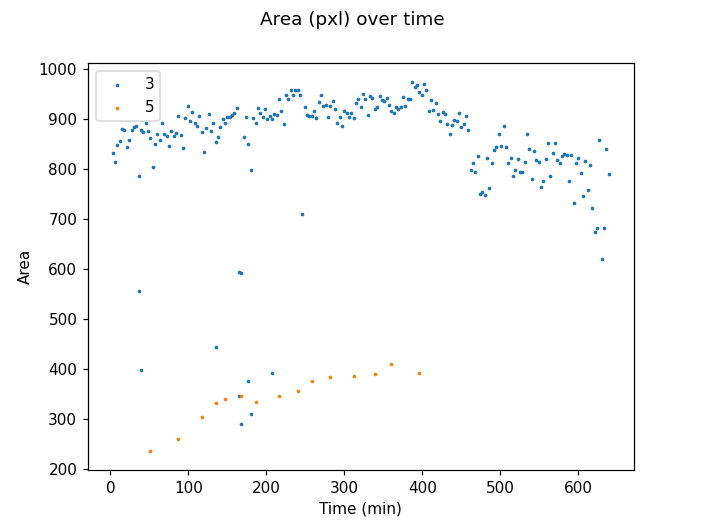

/home/p301081/yeastcells-detection-maskrcnn/yeastcells/visualize.py:259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


In [18]:
time_min = np.array(pred_df['Time(min)'])
ax = visualize.plot_area_profiles(mask_areas, time_min, labels, label_list=[3,5], ax=None, title="Area (pxl) over time")

In [24]:
# image_f = data.read_image(fn, time_series = True, channel=5, flourescent=True)
# pi = features.get_pixel_intensity(masks, output, image_f)
# pred_df['Pixel_intensity'] = pi

<IPython.core.display.Javascript object>


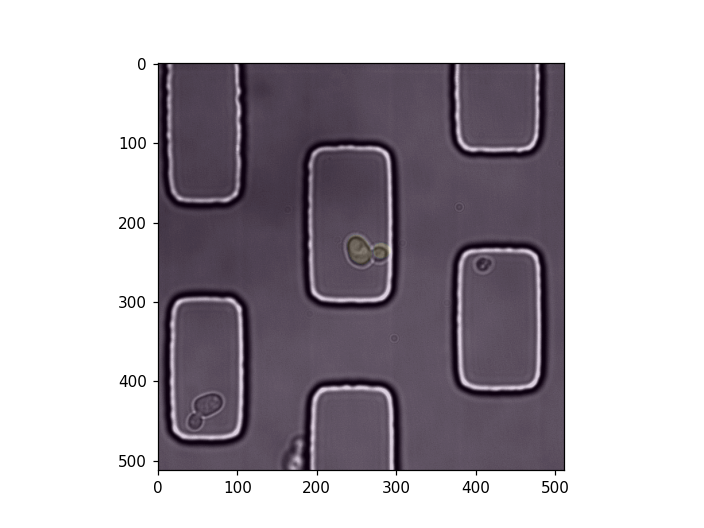

In [19]:
visualize.plot_mask_overlay(
    masks, labels, output, image, 
    label_list=[3,5], frame=5, ax=None, title=None
)

#### Output for tracked cells

In [39]:
agr = features.get_average_growth_rate(mask_areas, labels, output)
area_std = features.get_area_std(labels, pred_df)
position_std = features.get_position_std(labels, pred_df)

In [40]:
label_df = pd.DataFrame(agr, columns=['Cell_label', 'Average Growth Rate'])
label_df['Std Area(pxl)'] = area_std[:,1]
label_df['Std Position'] = position_std[:,1]

In [41]:
label_df['Cell_label'] = label_df['Cell_label'].astype(int)
label_df.head(5)

,Cell_label,Average Growth Rate,Std Area(pxl),Std Position
0,0,-0.000374,3.227296,0.415389
1,1,0.000353,1.930905,0.500000
2,2,-0.000170,3.504370,0.569134
3,3,-0.000242,112.847748,2.994317
4,4,0.001589,127.284720,1.526870


### Export

In [31]:
# pred_df = pred_df[pred_df.Cell_label!=-1] #remove untracked segmented cells
# pred_df = pred_df.sort_values(['Cell_label', 'Frame_number']) #sort by tracking label
# pred_df = pred_df.reset_index(drop=True)
df_out = 'predictions'
pred_df.to_csv(f'{df_out}.csv', index=False)

#### Export masks as tiff stack file


In [ ]:
masks_out = 'masks'
with tifffile.TiffWriter(f'{masks_out}.tif') as stack:
    for m in masks:
        stack.save(m)